In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
from pathlib import Path

ROOT = Path(r"C:\Users\Venu\Documents\dl\chest_xray")

DATA_DIR  = ROOT
TRAIN_DIR = DATA_DIR / "train"
VAL_DIR   = DATA_DIR / "val"
TEST_DIR  = DATA_DIR / "test"




# Importing the necessary libraries

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

In [ ]:
IMG_SIZE = 150   # or 150 (must be SAME everywhere)

def get_training_data(data_dir):
    data = []
    labels = ["PNEUMONIA", "NORMAL"]

    data_dir = str(data_dir)  # Path → string

    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)

        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

                if img_arr is None:
                    continue  # skip broken images

                img_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
                data.append([img_arr, class_num])

            except Exception as e:
                print("Skipped:", img, e)

    return data  


# Loading the Dataset

In [23]:
from pathlib import Path

BASE_DIR = Path(r"C:\Users\Venu\Documents\dl\chest_xray")

print("Base dir exists:", BASE_DIR.exists())


Base dir exists: True


In [24]:
train = get_training_data(BASE_DIR / "train")
test  = get_training_data(BASE_DIR / "test")
val   = get_training_data(BASE_DIR / "val")


# Data Visualization & Preprocessing

<Axes: xlabel='count'>

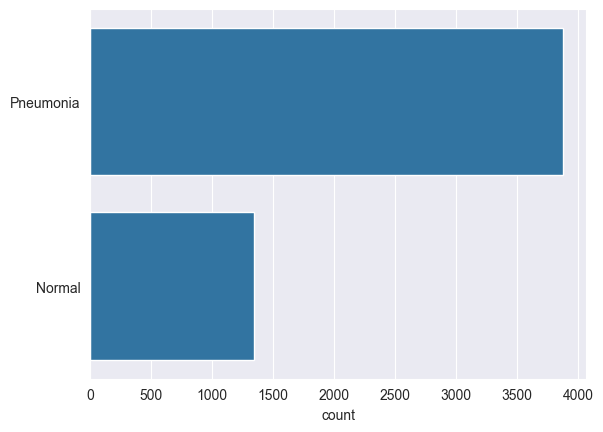

In [25]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)        

**The data seems imbalanced . To increase the no. of training examples, we will use data augmentation**

**Previewing the images of both the classes**

Text(0.5, 1.0, 'NORMAL')

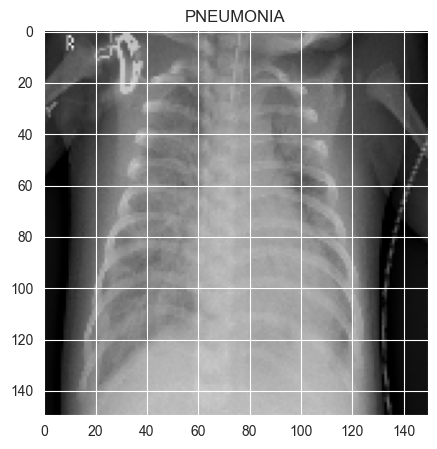

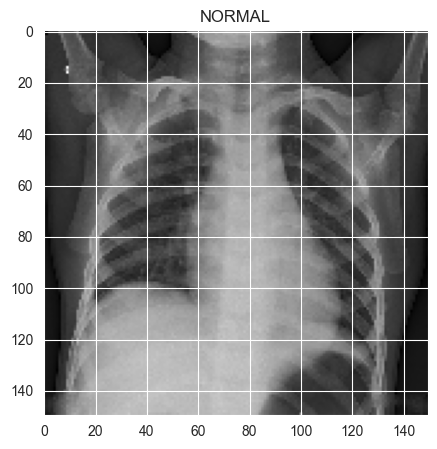

In [26]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [27]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

**We perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].**

In [28]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [29]:
# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

# Data Augmentation


In [30]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

For the data augmentation, i choosed to :
1. Randomly rotate some training images by 30 degrees 
2. Randomly Zoom by 20% some training images
3. Randomly shift images horizontally by 10% of the width 
4. Randomly shift images vertically by 10% of the height 
5. Randomly flip images horizontally.
Once our model is ready, we fit the training dataset.

# Training the Model

In [31]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

c:\Users\Venu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 38, 38, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 38, 38, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 19, 19, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 1,246,401 (4.75 MB)

 Trainable params: 1,245,313 (4.75 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [32]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [33]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

c:\Users\Venu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 129s 750ms/step - accuracy: 0.8395 - loss: 0.5692 - val_accuracy: 0.5000 - val_loss: 55.5774 - learning_rate: 0.0010
Epoch 2/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 52s 320ms/step - accuracy: 0.9018 - loss: 0.2573 - val_accuracy: 0.5000 - val_loss: 12.9759 - learning_rate: 0.0010
Epoch 3/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.9176 - loss: 0.2331
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 ━━━━━━━━━━━━━━━━━━━━ 53s 327ms/step - accuracy: 0.9248 - loss: 0.2167 - val_accuracy: 0.5000 - val_loss: 9.2509 - learning_rate: 0.0010
Epoch 4/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 55s 336ms/step - accuracy: 0.9446 - loss: 0.1474 - val_accuracy: 0.5000 - val_loss: 10.6275 - learning_rate: 3.0000e-04
Epoch 5/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.9541 - loss: 0.1401
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
163/163 ━━━━━━━━━━━━━━━━━━━━ 54s 332ms/step - accuracy:

In [34]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9263 - loss: 0.2580
Loss of the model is -  0.258025199174881
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9263 - loss: 0.2580
Accuracy of the model is -  92.62820482254028 %


# Analysis after Model Training

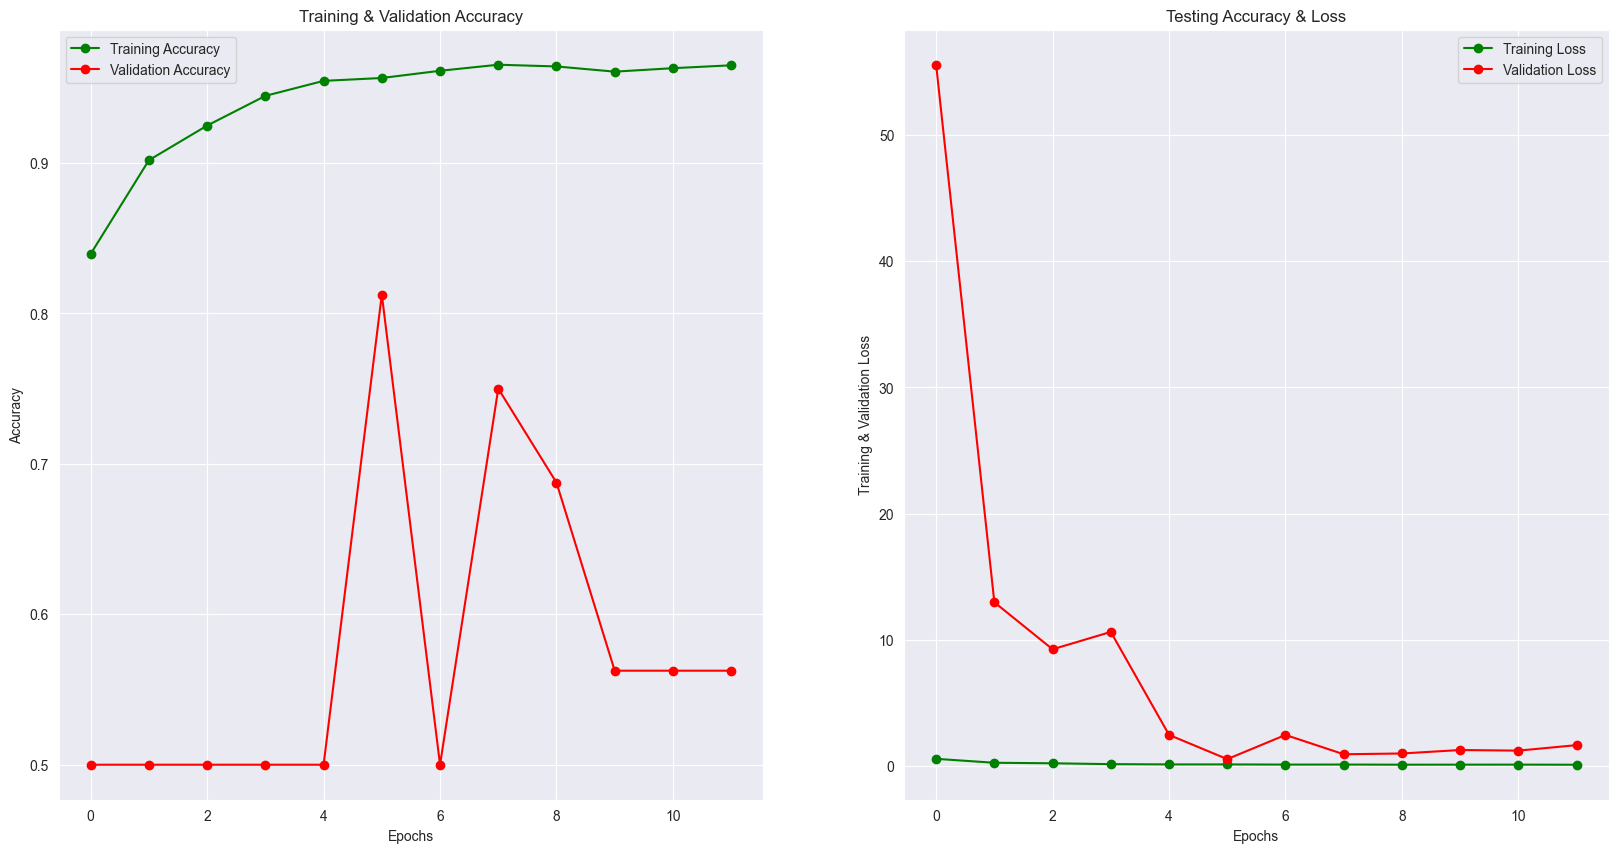

In [35]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [37]:
y_pred_prob = model.predict(x_test)
predictions = (y_pred_prob > 0.5).astype("int32").reshape(-1)
predictions[:15]

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [38]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.93      0.96      0.94       390
   Normal (Class 1)       0.93      0.87      0.90       234

           accuracy                           0.93       624
          macro avg       0.93      0.92      0.92       624
       weighted avg       0.93      0.93      0.93       624



In [39]:
cm = confusion_matrix(y_test,predictions)
cm

array([[374,  16],
       [ 30, 204]])

In [40]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<Axes: >

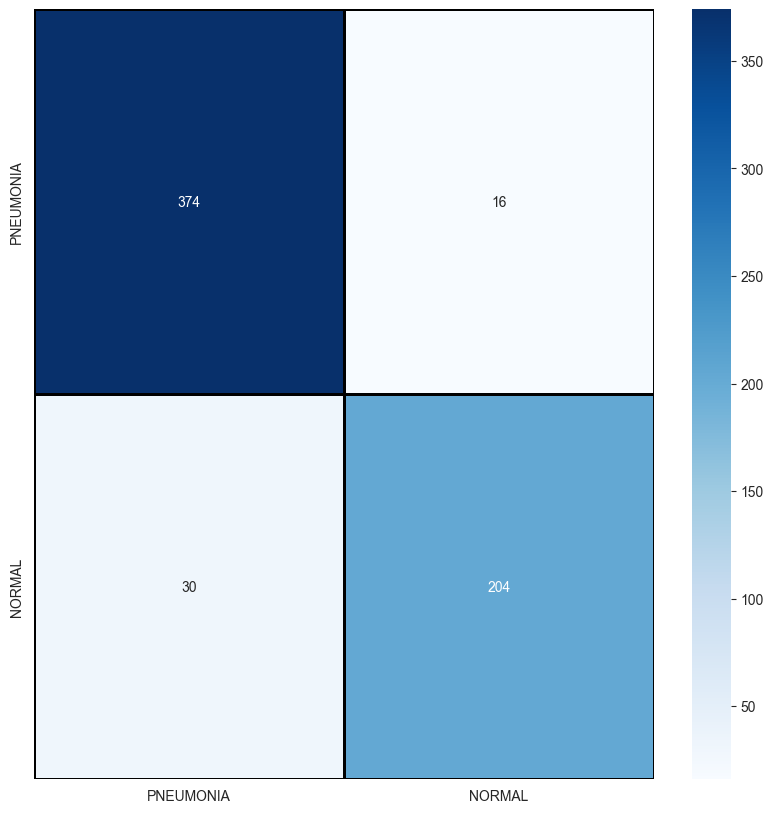

In [41]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [42]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

In [45]:
# Save model in native Keras format
model.save("pneumonia_cnn_model.keras")
print("Model saved as pneumonia_cnn_model.keras")


Model saved as pneumonia_cnn_model.keras
